In [13]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4, 3),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [14]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'chaos1'
config_ext = '.conf'

In [15]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [16]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    # print(f"Running with config file {config_file}")
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    # print(f"Running command `{cmd}`")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    # print("Done")

In [17]:
def load_conf() -> dict:
    conf = {}
    with open(path + config_path + config_name + config_ext, 'r') as f:
        lines = f.read().split('\n')

    for line in lines:
        if not line:
            continue
        name, _, val, *_ = line.split(' ')
        name = name.strip()
        val = val.strip()
        try:
            conf[name] = float(val)
        except ValueError:
            conf[name] = val
    
    return conf

In [18]:
nsteps = np.linspace(1000, 10000, 10)

conf = load_conf()

omega0 = np.sqrt(conf['g']/conf['L'])
omega = 2*omega0
assert conf['Omega'] == omega
tFin = 2 * np.pi / omega

In [19]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [20]:
params_variations = {
    'nsteps': nsteps,
    'N': (10, 20),
}
all_params = tuple(
    {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
)

# Run simulations
outputs = []  # List to store output file names
for i, params in enumerate(all_params):
    output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
    outputs.append(output_file)
    run(f'{config_path}{config_name}{config_ext}', output_file, params)
    print(f'\rRunning simulation {i}/{len(all_params)}', end='')
print('\nDone!')

Running simulation 19/20
Done!


In [21]:
# Load stuff in memory
all_data = {}
all_10_periods = {}
all_20_periods = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, data)
    if params['N'] == 10:
        all_10_periods[file] = (params, data)
    elif params['N'] == 20:
        all_20_periods[file] = (params, data)
    else:
        print('FEUR ALERT')

# Plots!

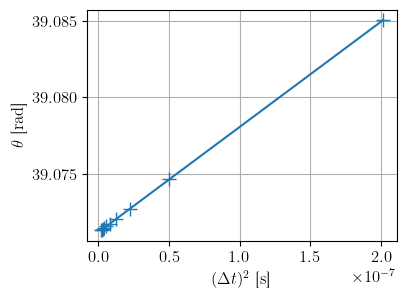

In [22]:
def calc(dataset: dict):
    stuffies = []
    for i, (params, data) in enumerate(dataset.values()):
        tf, thetaf = data[:, 0], data[-1, 1]
        stuffies.append(thetaf)
    return stuffies

norder = 2
period = 2 * np.pi / omega
dt = period / nsteps
stuff = calc(all_10_periods)
plt.plot(dt**norder, stuff, '+-', label=r'$\theta$')
plt.xlabel(r'$(\Delta t)^2$ [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid()
plt.savefig(export_path + 'chaos1_10_periods_conv.pdf')

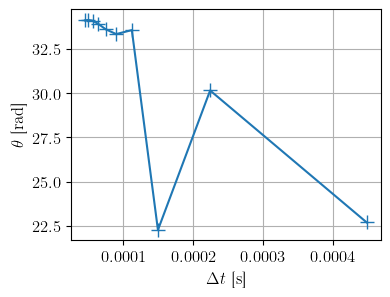

In [23]:
def calc(dataset: dict):
    stuffies = []
    for i, (params, data) in enumerate(dataset.values()):
        tf, thetaf = data[:, 0], data[-1, 1]
        stuffies.append(thetaf)
    return stuffies

norder = 1
period = 2 * np.pi / omega
dt = period / nsteps
stuff = calc(all_20_periods)
plt.plot(dt**norder, stuff, '+-', label=r'$\theta$')
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid()
plt.savefig(export_path + 'chaos1_20_periods_conv.pdf')